# The effect of the review score on your AirBnB.

This notebook will explore, the effect of the review score on your AirBnB, following the CRISP-DM structure:

1) Business Understanding

2) Data Understanding

3) Prepare data

4) Data modelling

5) Evaluate the results

## Business Understanding
In order to to answer the overarching question I will explore the following three questions:
    
1) Does price of the properties infuence the review scores?

2) Do properties with booking flexibility have higher reviews?

3) What is the relationship between reviews and booked frequency? 

## Data Understanding
The notebook explores the Seattle AirBnB dataset available at this link: 
https://www.kaggle.com/airbnb/seattle

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
%matplotlib inline 

In [2]:
# Import data
calendar = pd.read_csv("calendar.csv")
listings = pd.read_csv("listings.csv")
reviews = pd.read_csv("reviews.csv")

In [3]:
# Exploring calendar dataset
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
# Exploring listings dataset
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [5]:
# Exploring reviews dataset
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


The business questions focus on the following attributes which are available in the corresponding datasets:

1) Price - calendar dataset

2) Availability - calendar dataset

3) Cancellation policy - listings dataset

4) Review score - listings dataset

## Prepare data

### Preparing calendar dataset

In [6]:
# Exploring the scope of the fields of interest
dates = calendar['date'].nunique()
missing_availability = sum(calendar.groupby('listing_id')['available'].count() != 365)
missing_prices = sum(calendar.groupby('listing_id')['price'].count() != 365)

print ("There is data for", dates, "days")
print ("There are", missing_availability, "rows missing availability")
print ("There are", missing_prices, "rows missing prices")

There is data for 365 days
There are 0 rows missing availability
There are 3140 rows missing prices


In [7]:
# Transforming availability column to boolean format
calendar['available'] = calendar['available'] == 't'
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,$85.00
1,241032,2016-01-05,True,$85.00
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


In [8]:
# Calculating the number and percentage of days that a property was available
availability = calendar[['listing_id', 'available']].groupby('listing_id').sum().rename(columns={"available": "days_available"})
availability['percentage_available'] = availability.apply(lambda x: round((x/365)* 100, 2))
availability.head()

,days_available,percentage_available
listing_id,,
3335,309.0,84.66
4291,365.0,100.00
5682,309.0,84.66
6606,365.0,100.00
7369,53.0,14.52


In [9]:
# Converting prices to floats
calendar['price'] = calendar['price'].astype(str).str.replace(',', '').str.replace('$', '')
calendar['price'] = calendar['price'].apply(lambda x: float(x))
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


In [10]:
# Calculating max, min, average prices and variation
price = calendar[['listing_id', 'price']].groupby('listing_id').max().rename(columns={"price": "max_price"})
price['min_price'] = calendar[['listing_id', 'price']].groupby('listing_id').min()
price['avg_price'] = calendar[['listing_id', 'price']].groupby('listing_id').mean().round(1)
price['price_variation'] = price['max_price']-price['min_price']
price.head()

,max_price,min_price,avg_price,price_variation
listing_id,,,,
3335,120.0,120.0,120.0,0.0
4291,82.0,82.0,82.0,0.0
5682,60.0,42.0,53.9,18.0
6606,100.0,90.0,92.8,10.0
7369,85.0,85.0,85.0,0.0


In [11]:
# Calculating properties with missing prices
missing = round(np.sum(price['max_price'].isnull())/price.shape[0] * 100, 2)
print (missing, "% of listings are missing max prices")

2.49 % of listings are missing max prices


### Preparing listings dataset

In [12]:
# Defining scope of analysis, for example text fields are not included for simplicity
listings = listings[['id', 'experiences_offered', 'review_scores_value', 'jurisdiction_names', 'instant_bookable',
                    'cancellation_policy', 'require_guest_profile_picture','require_guest_phone_verification',
                    'calculated_host_listings_count', 'reviews_per_month']]

### Preparing combined dataset

In [13]:
# Merging listing, availability and price information together
summary = pd.merge(listings, availability, left_on='id', right_on='listing_id', how='left')
summary = pd.merge(summary, price, left_on='id', right_on='listing_id', how='left')
summary.head()

,id,experiences_offered,review_scores_value,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days_available,percentage_available,max_price,min_price,avg_price,price_variation
0,241032,none,10.0,WASHINGTON,f,moderate,f,f,2,4.07,346.0,94.79,85.0,85.0,85.0,0.0
1,953595,none,10.0,WASHINGTON,f,strict,t,t,6,1.48,291.0,79.73,439.0,125.0,170.9,314.0
2,3308979,none,10.0,WASHINGTON,f,strict,f,f,2,1.15,220.0,60.27,1650.0,500.0,1301.8,1150.0
3,7421966,none,NaN,WASHINGTON,f,flexible,f,f,1,NaN,143.0,39.18,100.0,100.0,100.0,0.0
4,278830,none,9.0,WASHINGTON,f,strict,f,f,1,0.89,365.0,100.00,600.0,450.0,462.7,150.0


In [14]:
# Find number of rows which are missing all values
all_missing = summary[summary.isnull().all(1)].shape[0]
print ("There are", all_missing, "rows missing all values therefore none need to be completely removed")

There are 0 rows missing all values therefore none need to be completely removed


In [15]:
np.sum(summary.isnull())

id                                    0
experiences_offered                   0
review_scores_value                 656
jurisdiction_names                    0
instant_bookable                      0
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   627
days_available                        0
percentage_available                  0
max_price                            95
min_price                            95
avg_price                            95
price_variation                      95
dtype: int64

Although no rows are missing all information, there are quite a few rows missing price and review information

In [16]:
# Tidy up fields, turning those containing t and f to boolean and objects to strings
summary['experiences_offered'] = summary['experiences_offered'] != "none"
summary[['instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']]  = summary[['instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']] == "t"
summary[['jurisdiction_names', 'cancellation_policy']] = summary[['jurisdiction_names', 'cancellation_policy']].astype(str)
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 16 columns):
id                                  3818 non-null int64
experiences_offered                 3818 non-null bool
review_scores_value                 3162 non-null float64
jurisdiction_names                  3818 non-null object
instant_bookable                    3818 non-null bool
cancellation_policy                 3818 non-null object
require_guest_profile_picture       3818 non-null bool
require_guest_phone_verification    3818 non-null bool
calculated_host_listings_count      3818 non-null int64
reviews_per_month                   3191 non-null float64
days_available                      3818 non-null float64
percentage_available                3818 non-null float64
max_price                           3723 non-null float64
min_price                           3723 non-null float64
avg_price                           3723 non-null float64
price_variation                     3723 

In [17]:
summary.head()

,id,experiences_offered,review_scores_value,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days_available,percentage_available,max_price,min_price,avg_price,price_variation
0,241032,False,10.0,WASHINGTON,False,moderate,False,False,2,4.07,346.0,94.79,85.0,85.0,85.0,0.0
1,953595,False,10.0,WASHINGTON,False,strict,True,True,6,1.48,291.0,79.73,439.0,125.0,170.9,314.0
2,3308979,False,10.0,WASHINGTON,False,strict,False,False,2,1.15,220.0,60.27,1650.0,500.0,1301.8,1150.0
3,7421966,False,NaN,WASHINGTON,False,flexible,False,False,1,NaN,143.0,39.18,100.0,100.0,100.0,0.0
4,278830,False,9.0,WASHINGTON,False,strict,False,False,1,0.89,365.0,100.00,600.0,450.0,462.7,150.0


In [18]:
# All fields appear to show 'WASHINGTON' for jurisdiction name. This provides no information and so it can be removed
summary.groupby('jurisdiction_names').count()
summary = summary.drop('jurisdiction_names', axis = 1)

In [19]:
# Similarly, all fields appear to be 'False' for experiences offered. This provides no information and so it can be removed
summary.groupby('experiences_offered').count()
summary = summary.drop('experiences_offered', axis = 1)

In [20]:
np.sum(summary['cancellation_policy'].isnull())
# There are no rows missing for 'cancellation policy'. As it is a categorical variable, dummy variables need to be created to feed this feature into the model
summary2 = pd.concat([summary.drop('cancellation_policy', axis=1), pd.get_dummies(summary['cancellation_policy'])], axis=1) 
summary2

,id,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days_available,percentage_available,max_price,min_price,avg_price,price_variation,flexible,moderate,strict
0,241032,10.0,False,False,False,2,4.07,346.0,94.79,85.0,85.0,85.0,0.0,0,1,0
1,953595,10.0,False,True,True,6,1.48,291.0,79.73,439.0,125.0,170.9,314.0,0,0,1
2,3308979,10.0,False,False,False,2,1.15,220.0,60.27,1650.0,500.0,1301.8,1150.0,0,0,1
3,7421966,NaN,False,False,False,1,NaN,143.0,39.18,100.0,100.0,100.0,0.0,1,0,0
4,278830,9.0,False,False,False,1,0.89,365.0,100.00,600.0,450.0,462.7,150.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,8.0,False,False,False,8,0.30,32.0,8.77,359.0,359.0,359.0,0.0,0,0,1
3814,8902327,10.0,False,False,False,1,2.00,273.0,74.79,125.0,51.0,100.2,74.0,0,1,0
3815,10267360,NaN,False,False,False,1,NaN,88.0,24.11,93.0,75.0,87.9,18.0,0,1,0
3816,9604740,NaN,False,False,False,1,NaN,179.0,49.04,99.0,99.0,99.0,0.0,0,1,0


In [21]:
# Create list of numeric variables so that missing values can be imputed (although from earlier we know only price values are missing)
# Questions focus on availablity and reviews and so these fields will not be imputed
num_vars = summary.select_dtypes(include=['float', 'int']).columns
num_vars = num_vars[num_vars != ('days_available')]
num_vars = num_vars[num_vars != ('percentage_available')]
num_vars = num_vars[num_vars != ('review_scores_value')]
num_vars

Index(['id', 'calculated_host_listings_count', 'reviews_per_month',
       'max_price', 'min_price', 'avg_price', 'price_variation'],
      dtype='object')

In [22]:
# Create function which fills missing values in columns within num_vars with the column mean
def fill_mean(df, num_vars):
    '''
    INPUT:
    df - dataframe with missing numeric values
    num_vars - object containing numeric columns in dataframe
    OUTPUT:
    df - dataframe with missing numeric values filled with column means
    
    Fills missing numeric values within a dataframe with column means.
    '''
    for col in num_vars:
            df[col] = df[col].fillna(df[col].mean(), axis = 0)
    return df

In [23]:
# Use function on dataframe to fill missing numeric values with column means
filled_summary = fill_mean(summary2, num_vars)
filled_summary

,id,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days_available,percentage_available,max_price,min_price,avg_price,price_variation,flexible,moderate,strict
0,241032,10.0,False,False,False,2,4.070000,346.0,94.79,85.0,85.0,85.0,0.0,0,1,0
1,953595,10.0,False,True,True,6,1.480000,291.0,79.73,439.0,125.0,170.9,314.0,0,0,1
2,3308979,10.0,False,False,False,2,1.150000,220.0,60.27,1650.0,500.0,1301.8,1150.0,0,0,1
3,7421966,NaN,False,False,False,1,2.078919,143.0,39.18,100.0,100.0,100.0,0.0,1,0,0
4,278830,9.0,False,False,False,1,0.890000,365.0,100.00,600.0,450.0,462.7,150.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,8.0,False,False,False,8,0.300000,32.0,8.77,359.0,359.0,359.0,0.0,0,0,1
3814,8902327,10.0,False,False,False,1,2.000000,273.0,74.79,125.0,51.0,100.2,74.0,0,1,0
3815,10267360,NaN,False,False,False,1,2.078919,88.0,24.11,93.0,75.0,87.9,18.0,0,1,0
3816,9604740,NaN,False,False,False,1,2.078919,179.0,49.04,99.0,99.0,99.0,0.0,0,1,0


In [24]:
# Removing ID as this shouldn't be a predictor in the model
filled_summary = filled_summary.drop('id', axis = 1)

In [25]:
np.sum(filled_summary.isnull())

review_scores_value                 656
instant_bookable                      0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                     0
days_available                        0
percentage_available                  0
max_price                             0
min_price                             0
avg_price                             0
price_variation                       0
flexible                              0
moderate                              0
strict                                0
dtype: int64

In [26]:
# Calculate % of listings missing a review score
missing_review = round(sum(filled_summary.review_scores_value.isnull())/filled_summary.shape[0] * 100, 2)
print (missing_review, "% of listings are missing a review score")

17.18 % of listings are missing a review score


In [27]:
# Create dataset for modelling review scores and remove rows with no review score, as in these cases we don't have values to predict
reviews = filled_summary.dropna(subset = ['review_scores_value'], how = 'any')
np.sum(reviews.isnull())

review_scores_value                 0
instant_bookable                    0
require_guest_profile_picture       0
require_guest_phone_verification    0
calculated_host_listings_count      0
reviews_per_month                   0
days_available                      0
percentage_available                0
max_price                           0
min_price                           0
avg_price                           0
price_variation                     0
flexible                            0
moderate                            0
strict                              0
dtype: int64

In [28]:
# Create dataset for modelling availability with rows missing review scores imputed with mean values
availability_dataset = fill_mean(filled_summary, ['review_scores_value'])
np.sum(availability_dataset.isnull())

review_scores_value                 0
instant_bookable                    0
require_guest_profile_picture       0
require_guest_phone_verification    0
calculated_host_listings_count      0
reviews_per_month                   0
days_available                      0
percentage_available                0
max_price                           0
min_price                           0
avg_price                           0
price_variation                     0
flexible                            0
moderate                            0
strict                              0
dtype: int64

## Data Modelling

### Linear model to predict review scores

In [29]:
# y set to the target variable (review_scores_value) and everything else set to X
y = reviews['review_scores_value']
X= reviews.drop('review_scores_value', axis = 1)

In [30]:
# Split data into a train and test dataset. The test dataset is 33% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
# Create a linear model object
lm_model = LinearRegression()

In [32]:
# Fit model on training data
lm_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
# Use model to predict based on test dataset
predictions = lm_model.predict(X_test)

In [34]:
# Evaluate prediction power
reviews_r2_score = round(r2_score(y_test, predictions), 3)
print ("The R2 score of the reviews linear model is", reviews_r2_score)

The R2 score of the reviews linear model is 0.06


### Linear model to predict availability

In [35]:
# Repeating the steps above to predict percentage availability
y2 = availability_dataset['percentage_available']
X2 = availability_dataset.drop('percentage_available', axis = 1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=101)
lm_model2 = LinearRegression()
lm_model2.fit(X_train2, y_train2)
predictions2 = lm_model2.predict(X_test2)
availability_r2_score = round(r2_score(y_test2, predictions2), 3)
print ("The R2 score of the availability linear model is", availability_r2_score)

The R2 score of the availability linear model is 1.0


## Evaluate the results

My three questions were:
    
1) Does price of the properties infuence the review scores?

2) Do properties with booking flexibility have higher reviews?

3) What is the relationship between reviews and booked frequency?

I will now use the models created to evaluate the answers to these questions

In [36]:
# Create function to summarise coefficients of features in model
def summarise_feature_coefficients(coefficients, X_train):
    '''
    INPUT:
    coefficients - linear model coefficients
    X_train - training dataset to provide feature names
    OUTPUT:
    coefs_df - dataframe containing model features and their corresponding coefficients and absolute coefficients
    
    Creates dataframe containing model features and their model coefficients (both raw and absolute) to evaluate
    the most influential features in the linear model.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['features'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [37]:
# Use function to create a summary of coefficient in reviews linear model
coef_df = summarise_feature_coefficients(lm_model.coef_, X_train)

In [38]:
# Use function to create a summary of coefficient in availability linear model
coef_df2 = summarise_feature_coefficients(lm_model.coef_, X_train2)

#### 1) Does price of the properties infuence the review scores?


In [39]:
# Coefficients of reviews linear model 
coef_df

,features,coefs,abs_coefs
6,percentage_available,-6.485293,6.485293
5,days_available,1.776395,1.776395
2,require_guest_phone_verification,-0.048229,0.048229
4,reviews_per_month,0.034088,0.034088
11,flexible,0.029918,0.029918
1,require_guest_profile_picture,-0.025006,0.025006
13,strict,-0.022776,0.022776
3,calculated_host_listings_count,-0.021152,0.021152
0,instant_bookable,0.015242,0.015242
12,moderate,-0.007141,0.007141


The coefficients for all price features are very low indicating that there is a very small relationship between price and review score. The coefficient for average price is actually negative indicating that cheaper properties on average have a slightly higher review score. In conclusion, do more expensive properties tend to have higher reviews, no.

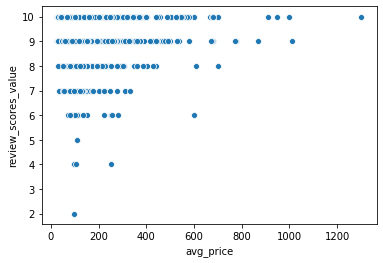

In [40]:
# Plot of review scores vs average price
sns.scatterplot(x = 'avg_price', y = 'review_scores_value', data = reviews)

This is further demonstrated by the splot above. Although there is a weak correlation between average price and review score, there are a lot of cheap properties with high scores.
The following verifies that this is being skewed by properties with few reviews

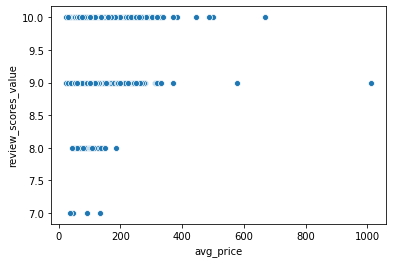

In [41]:
# Find out average number of reviews per month and then plot only for properties with > 2 reviews per month
reviews['reviews_per_month'].describe()
sns.scatterplot(x = 'avg_price', y = 'review_scores_value', data = reviews[reviews['reviews_per_month'] > 2])

#### 2. Do properties with booking flexibility have higher reviews?

In [42]:
# Coefficients of reviews linear model 
coef_df

,features,coefs,abs_coefs
6,percentage_available,-6.485293,6.485293
5,days_available,1.776395,1.776395
2,require_guest_phone_verification,-0.048229,0.048229
4,reviews_per_month,0.034088,0.034088
11,flexible,0.029918,0.029918
1,require_guest_profile_picture,-0.025006,0.025006
13,strict,-0.022776,0.022776
3,calculated_host_listings_count,-0.021152,0.021152
0,instant_bookable,0.015242,0.015242
12,moderate,-0.007141,0.007141


Properties with flexible booking policies tend to have higher review scores and those with strict policies tend to have lower review scores. However, coefficients aren't high suggesting a moderate correlation.
In conclusion, do properties with booking flexibility have higher reviews, yes but the relationship is marginal

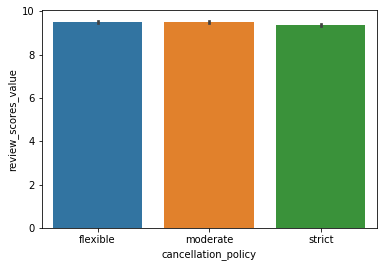

In [43]:
# Bar plot of review scores by cancellation policy
sns.barplot(x = 'cancellation_policy', y = 'review_scores_value', data = summary, order = ['flexible', 'moderate', 'strict'])

In [44]:
# Average review score by cancellation policy
summary.groupby('cancellation_policy')['review_scores_value'].mean()

cancellation_policy
flexible    9.504516
moderate    9.497790
strict      9.378981
Name: review_scores_value, dtype: float64

The above chart and figures are in line with the conclusion above. Flexible policy propeties on average have a marginally higher review score than moderate and strict policy properties. However, there is very little difference between them due to the vast number of 10 star reviews.

#### 3. What is the relationship between reviews and booked frequency?

In [45]:
# Coefficients of availability linear model 
coef_df2

,features,coefs,abs_coefs
6,days_available,-6.485293,6.485293
5,reviews_per_month,1.776395,1.776395
2,require_guest_profile_picture,-0.048229,0.048229
4,calculated_host_listings_count,0.034088,0.034088
11,flexible,0.029918,0.029918
1,instant_bookable,-0.025006,0.025006
13,strict,-0.022776,0.022776
3,require_guest_phone_verification,-0.021152,0.021152
0,review_scores_value,0.015242,0.015242
12,moderate,-0.007141,0.007141


The following suggests review score is a weak/moderate predictor of availaility and that properties with higher review scores are not more likely to be booked up.

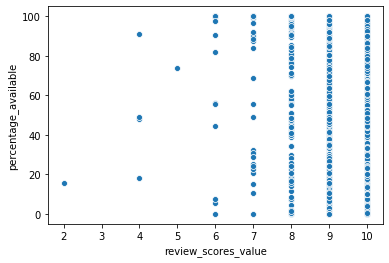

In [46]:
sns.scatterplot(x = 'review_scores_value', y = 'percentage_available', data = reviews)

The above chart shows there is very little relationship between review scores and percentage availabilty. In fact the properties with lowest review scores are marginally more likely to be booked up.